In [70]:
import sys 
sys.path.insert(-1,"../")
from mazeAgentUtils import *

%load_ext autoreload
%autoreload 2

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
N=50
xcen = np.linspace(0,5,N+1)[:-1]
xcen += (xcen[1] - xcen[0]) / 2
ycen = np.array([0.1]*N)
centres = np.vstack((xcen,ycen)).T

#Default parameters for MazeAgent 
params = { 

          #Maze params 
          'mazeType'            : 'loop',                #type of maze, define in getMaze() function
          'stateType'           : 'gaussianThreshold',   #feature on which to TD learn (onehot, gaussian, gaussianCS, circles, bump)
          'movementPolicy'      : 'windowsScreensaver',  #movement policy (raudies, random walk, windows screensaver)
          'roomSize'            : 5,                     #maze size scaling parameter, metres
          'dt'                  : 0.005,                  #simulation time disretisation 
          'dx'                  : 0.01,
          'centres'             : centres,               #array of receptive field positions. Overwrites nCells
          'sigma'               : 1,                     #basis cell width scale (irrelevant for onehots)
          'doorsClosed'         : False,                 #whether doors are opened or closed in multicompartment maze
         
          'kappa'               : 1,
          'tau'                 : 4,
          'tau_STDP'            : 20e-3,
          'precessFraction'     : 0.6, 
          'peakFiringRate'      : 5,  
          'a_STDP_asymm'        : -0.8,
          'tau_STDP_asymm'      : 2
          }


agent =  MazeAgent(params)

Setting parameters
Initialising
   making state/history dataframes
   initialising velocity, position and direction
   setting time/run counters
   making the maze walls
   discretising position for later plotting
   handling undefined parameters
   initialising basis features for learning
   calculating state vector at all discretised positions


  0%|          | 0/10000 [00:00<?, ?it/s]

   initialising STDP weight matrix and traces
DONE


'../figures/211011/openloop_1758'

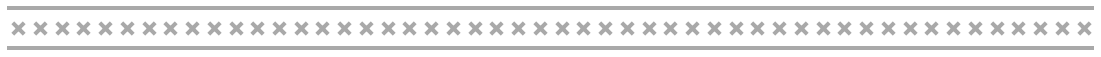

In [72]:
#FIGURE 2A
plotter = Visualiser(agent)
fig, ax = plotter.plotFeatureCells(centresOnly=True, textlabel=False,onepink=True)
saveFigure(fig,'openloop',specialLocation="../figures/paperFigures/figure2/2A.svg")


  0%|          | 0/12000 [00:00<?, ?it/s]

Calculating place and grid cells


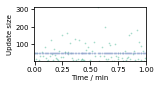

In [73]:
agent.runRat(trainTime=1,saveEvery=0.5)
plotter = Visualiser(agent)

'../figures/211011/Mvarerr_1649'

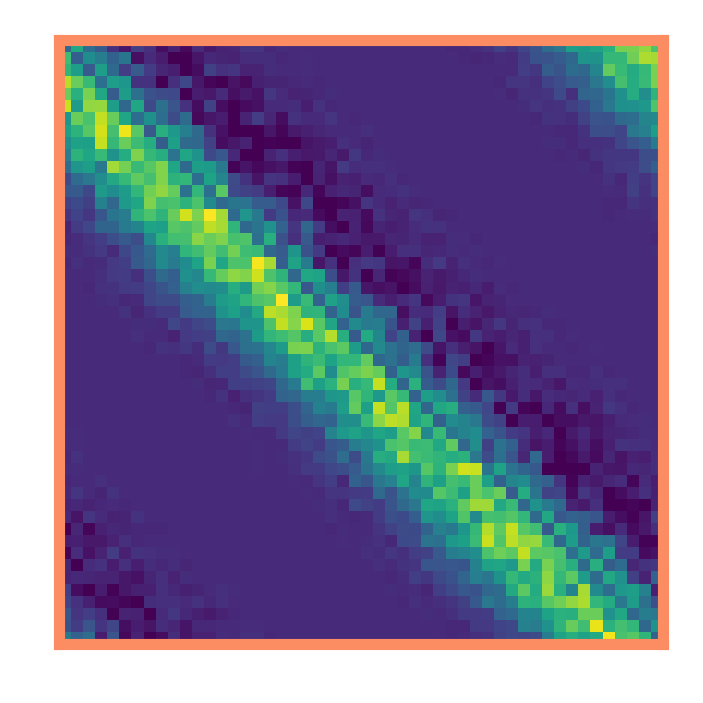

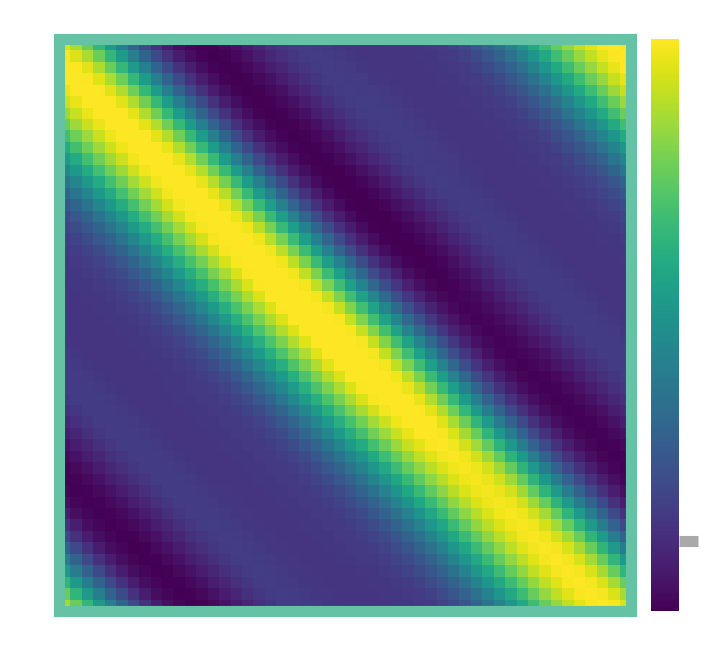

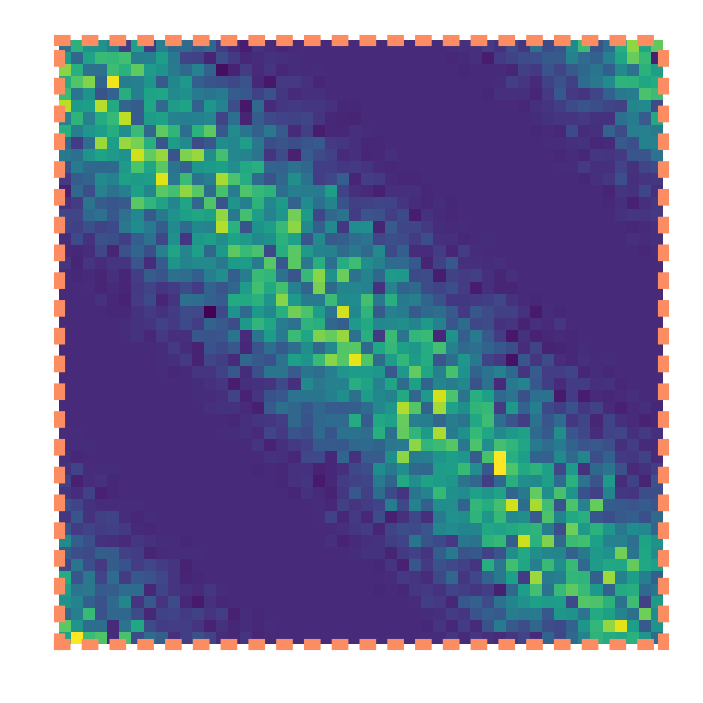

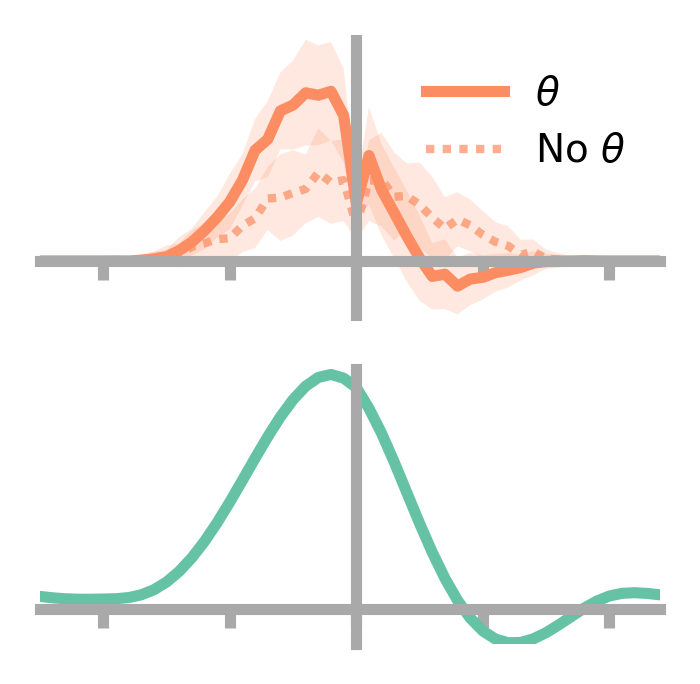

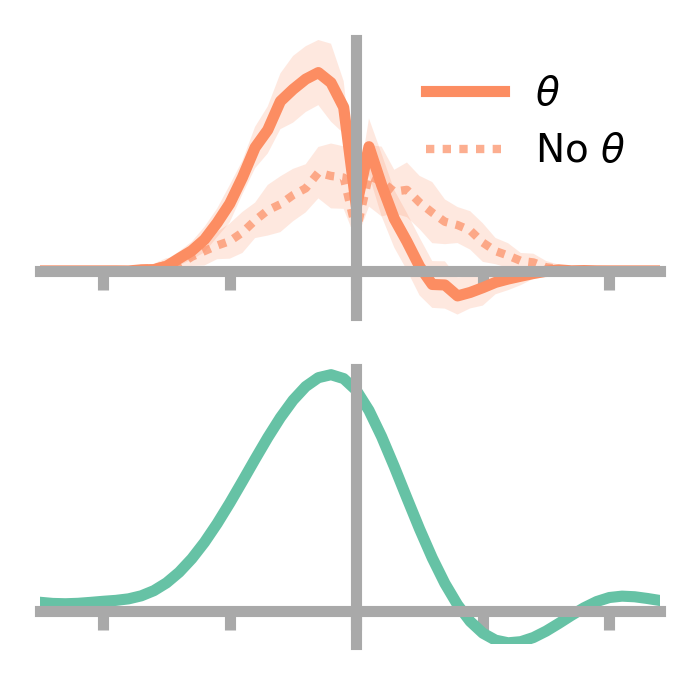

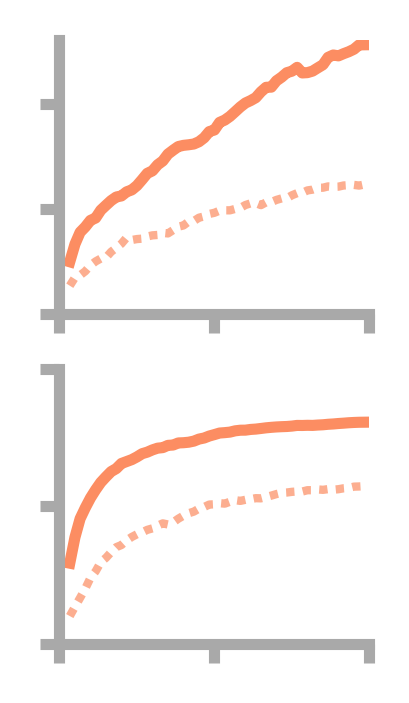

In [59]:
# #FIGURE 2B
fig, ax = plotter.plotM(whichM='W',colorbar=False,time=30)
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C1')
    spine.set_linewidth(2)
ax.set_xticks([])
ax.set_yticks([])
saveFigure(fig,'W',specialLocation='../figures/paperFigures/figure2/2B.svg')

#FIGURE 2C
fig, ax, cb, cax = plotter.plotM(whichM='M')
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C0')
    spine.set_linewidth(2)
cb.set_ticks([0])
cb.set_ticklabels([""])
cax.tick_params(color='darkgrey',width=2)
ax.set_xticks([])
ax.set_yticks([])
saveFigure(fig,'M',specialLocation='../figures/paperFigures/figure2/2C.svg')

#FIGURE 2C
fig, ax = plotter.plotM(whichM='W_notheta',colorbar=False,time=30)
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C1')
    spine.set_linewidth(2)
    spine.set_linestyle((0,(0.5,2)))
ax.set_xticks([])
ax.set_yticks([])
saveFigure(fig,'W_notheta')


#FIGURE 2D
fig, ax = plotter.plotMAveraged(time=10)
saveFigure(fig,'Mav',specialLocation='../figures/paperFigures/figure2/2D.svg')

fig, ax = plotter.plotMAveraged(time=30)
saveFigure(fig,'Mav',specialLocation='../figures/paperFigures/figure2/2D.svg')


#FIGURE 2E
fig, ax = plotter.plotVarianceAndError()
saveFigure(fig,'Mvarerr',specialLocation='../figures/paperFigures/figure2/2E.svg')



In [14]:
N=50
xcen = np.linspace(0,5,N+1)[:-1]
xcen += (xcen[1] - xcen[0]) / 2
ycen = np.array([0.1]*N)
centres = np.vstack((xcen,ycen)).T

# centres = np.array([[2.5,0.1],[2.6,0.1]])

#Default parameters for MazeAgent 
params2 = { 

          #Maze params 
          'mazeType'            : 'loop',                #type of maze, define in getMaze() function
          'stateType'           : 'gaussianThreshold',   #feature on which to TD learn (onehot, gaussian, gaussianCS, circles, bump)
          'movementPolicy'      : 'windowsScreensaver',  #movement policy (raudies, random walk, windows screensaver)
          'roomSize'            : 5,                     #maze size scaling parameter, metres
          'dt'                  : 0.002,                 #simulation time disretisation 
          'dx'                  : 0.01,
          'centres'             : centres,               #array of receptive field positions. Overwrites nCells
          'sigma'               : 1,                     #basis cell width scale (irrelevant for onehots)
          'doorsClosed'         : True,                 #whether doors are opened or closed in multicompartment maze
         
          'kappa'               : 1,
          'tau'                 : 4,
          'tau_STDP'            : 20e-3,
          'precessFraction'     : 0.6, 
          'peakFiringRate'      : 5,  
          'a_STDP_asymm'        : -0.8,
          'tau_STDP_asymm'      : 2
          }



agent2 =  MazeAgent(params2)

Setting parameters
Initialising
   making state/history dataframes
   initialising velocity, position and direction
   setting time/run counters
   making the maze walls
   discretising position for later plotting
   handling undefined parameters
   initialising basis features for learning
   calculating state vector at all discretised positions


  0%|          | 0/10000 [00:00<?, ?it/s]

   initialising STDP weight matrix and traces
DONE


'../figures/211011/openloop_0900'

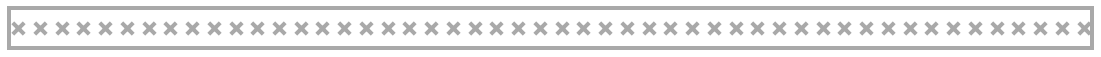

In [15]:
#FIGURE 2F
plotter2 = Visualiser(agent2)
fig, ax = plotter2.plotFeatureCells(centresOnly=True, textlabel=False,onepink=False)
saveFigure(fig,'openloop',specialLocation="../figures/paperFigures/figure2/2F.svg")


  0%|          | 0/900000 [00:00<?, ?it/s]

Calculating place and grid cells


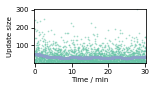

In [16]:
agent2.runRat(trainTime=30,saveEvery=0.5)
plotter2 = Visualiser(agent2)

'../figures/211011/Mvarerr_1200'

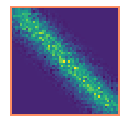

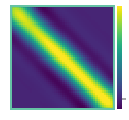

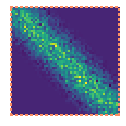

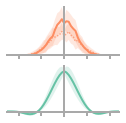

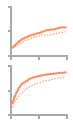

In [15]:
#FIGURE 2G
fig, ax = plotter2.plotM(whichM='W',colorbar=False,time=30)
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C1')
    spine.set_linewidth(2)
ax.set_xticks([])
ax.set_yticks([])
saveFigure(fig,'W',specialLocation='../figures/paperFigures/figure2/2G.svg')

#FIGURE 2H
fig, ax, cb, cax = plotter2.plotM()
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C0')
    spine.set_linewidth(2)
cb.set_ticks([0])
cb.set_ticklabels([""])
cax.tick_params(color='darkgrey',width=2)
ax.set_xticks([])
ax.set_yticks([])
saveFigure(fig,'M',specialLocation='../figures/paperFigures/figure2/2H.svg')

fig, ax = plotter2.plotM(whichM='W_notheta',colorbar=False)
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C1')
    spine.set_linewidth(2)
    spine.set_linestyle((0,(0.5,2)))
ax.set_xticks([])
ax.set_yticks([])
saveFigure(fig,'W_notheta')


#FIGURE 2IJ
fig, ax = plotter2.plotMAveraged()
ax[0].get_legend().set_visible(False) 
saveFigure(fig,'Mav',specialLocation='../figures/paperFigures/figure2/2I.svg')

fig, ax = plotter2.plotVarianceAndError()
saveFigure(fig,'Mvarerr',specialLocation='../figures/paperFigures/figure2/2J.svg')


In [18]:
#Default parameters for MazeAgent 
N = 200 
roomSize = 2.5
n = int(np.sqrt(N / 2))
delta = roomSize / n
x = np.arange(0,2.5,delta) + delta/2
y = np.arange(0,2.5,delta) + delta/2
xy = np.meshgrid(x,y)
centresL = []
for i in range(len(x)):
    for j in range(len(y)):
        centresL += [[x[i],y[j]]]
centresL = np.array(centresL)
centresR = centresL + np.array([2.5,0])
centres = np.vstack([centresL,centresR])
delta=0.45*delta
centres += np.random.uniform(-0.8*delta,0.8*delta,size=centres.shape)

params3 = { 

          #Maze params 
          'mazeType'            : 'twoRooms',                #type of maze, define in getMaze() function
          'stateType'           : 'gaussianThreshold',   #feature on which to TD learn (onehot, gaussian, gaussianCS, circles, bump)
          'movementPolicy'      : 'raudies',  #movement policy (raudies, random walk, windows screensaver)
          'roomSize'            : roomSize,                     #maze size scaling parameter, metres
          'dt'                  : 0.002,                 #simulation time disretisation 
          'dx'                  : 0.015,
          'centres'             : centres,               #array of receptive field positions. Overwrites nCells
          'sigma'               : 1,                     #basis cell width scale (irrelevant for onehots)
          'doorsClosed'         : False,                 #whether doors are opened or closed in multicompartment maze
          'firingRateLookUp'    : True,
          'rotSpeedScale'       : 1.5,
          'biasDoorCross'       : True,

          'kappa'               : 1,
          'tau'                 : 4,
          'tau_STDP'            : 20e-3,
          'precessFraction'     : 0.6, 
          'peakFiringRate'      : 5,  
          'a_STDP_asymm'        : -0.8,
          'tau_STDP_asymm'      : 2
          }

agent3 =  MazeAgent(params3)


Setting parameters
Initialising
   making state/history dataframes
   initialising velocity, position and direction
   setting time/run counters
   making the maze walls
   discretising position for later plotting
      dx must be an integer fraction of room size, setting it to 0.0150, 167 along room length
   handling undefined parameters
   initialising basis features for learning
   calculating state vector at all discretised positions


  0%|          | 0/55778 [00:00<?, ?it/s]

   initialising STDP weight matrix and traces
DONE


  0%|          | 0/1800000 [00:00<?, ?it/s]

crossed 17.358000000001258
crossed 65.2200000000294
crossed 76.90000000000218
crossed 89.11399999997371
time
time
time
crossed 220.49400000032472
time
crossed 357.57000000097923
crossed 395.03800000115814
crossed 432.0160000013347
crossed 453.0600000014352
crossed 488.36400000160376
crossed 544.4940000009482
crossed 600.7579999996177
crossed 645.7619999985535
crossed 732.8179999964949
crossed 780.4659999953682
crossed 793.7159999950549
crossed 844.1559999938621
crossed 860.7659999934693
crossed 873.4199999931701
crossed 931.9999999917849
crossed 983.3879999905697
crossed 1003.6619999900903
crossed 1036.8099999893066
crossed 1068.4579999885582
crossed 1084.9719999881677
crossed 1113.2659999874986
crossed 1133.1499999870284
time
crossed 1262.2279999839761
crossed 1317.9819999826577
crossed 1366.4239999815122
crossed 1380.8239999811717
crossed 1420.64999998023
time
time
time
crossed 1507.3239999781804
crossed 1560.0819999769328
crossed 1574.7139999765868
crossed 1600.2339999759834
crossed

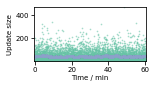

In [19]:
agent3.runRat(trainTime=60)
plotter3 = Visualiser(agent3)


0.7937929788940306


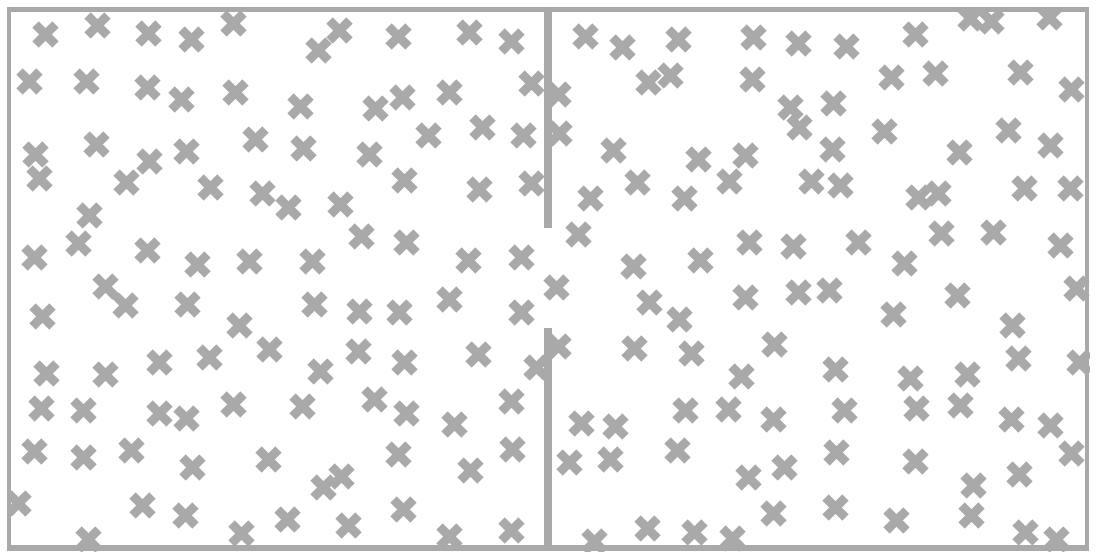

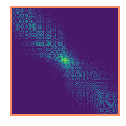

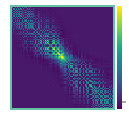

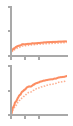

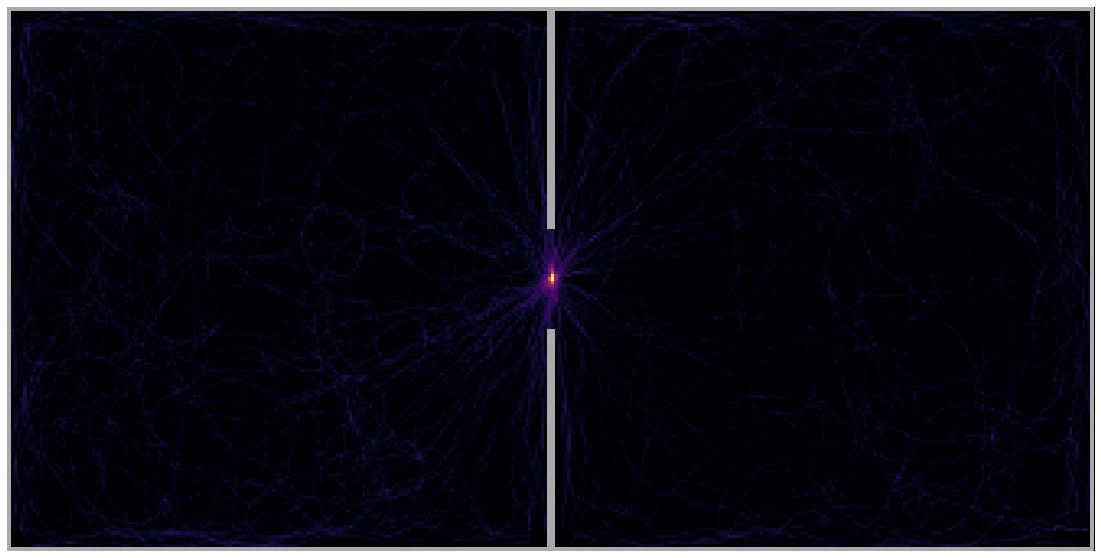

In [20]:
#FIGURE 2K
plotter3 = Visualiser(agent3)
fig, ax = plotter3.plotFeatureCells(centresOnly=True, textlabel=False)
# fig, ax  = plotter3.plotTrajectory(fig=fig, ax=ax, starttime=0, endtime=10)
saveFigure(fig, 'twoRoom',specialLocation="../figures/paperFigures/figure2/2K.svg")

#FIGURE 2L
fig, ax = plotter3.plotM(whichM='W',colorbar=False,time=60)
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C1')
    spine.set_linewidth(2)
ax.set_xticks([])
ax.set_yticks([])
saveFigure(fig,'W',specialLocation='../figures/paperFigures/figure2/2L.svg')

#FIGURE 2M
fig, ax, cb, cax = plotter3.plotM()
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C0')
    spine.set_linewidth(2)
cb.set_ticks([0])
cb.set_ticklabels([""])
cax.tick_params(color='darkgrey',width=2)
ax.set_xticks([])
ax.set_yticks([])
saveFigure(fig,'M',specialLocation='../figures/paperFigures/figure2/2M.svg')

fig, ax = plotter3.plotVarianceAndError()
saveFigure(fig,'Mvarerr',specialLocation='../figures/paperFigures/figure2/2N.svg')

plotter3.plotHeatMap()

print(R2(agent3.M,agent3.W))

In [21]:
import time 

overwrite = True

if overwrite == True:
    for i in range(10):
        print("WARNING! Overwriting in %g s" %(10-i)) 
        time.sleep(1) 
    pickleAndSave(agent,"openLoop")
    pickleAndSave(agent2,"closedLoop")
    pickleAndSave(agent3,"twoRooms")

WARNING! Overwriting in 10 s


In [2]:
loadfromsave = True
if loadfromsave == True:
    agent = loadAndDepickle("openLoop")
    agent2 = loadAndDepickle("closedLoop")
    agent3 = loadAndDepickle("twoRooms")

Receptive field (peak, mean, std, skew) = (3.545, 3.55, 0.434, -0.0)
Place field     (peak, mean, std, skew) = (3.205, 3.143, 0.528, -0.288)
peak shift           = -0.39 +- 0.03
receptive field skew =  -0.09 +- 0.49
place field skew     = -0.20 +- 0.06


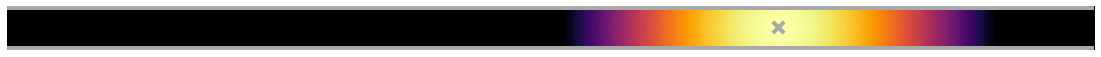

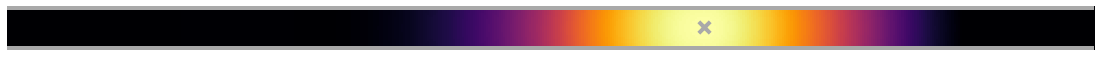

In [3]:
#FIGURE 3A
plotter = Visualiser(agent)
N = 35

fig, ax = plotter.plotReceptiveField(number=N)
saveFigure(fig,'openLoopStart',specialLocation="../figures/paperFigures/figure3/3Ai.svg")

fig, ax = plotter.plotPlaceField(time=10, number=N, STDP=True,threshold=0)
saveFigure(fig,'openLoopEnd',specialLocation="../figures/paperFigures/figure3/3Aii.svg")

placeFields = agent.getPlaceFields(M=agent.W,threshold=0)
x = agent.discreteCoords[10,:,0]
skew_PF = []
skew_RF = []
shift = []
for N in range(0,50):
    pf = placeFields[N][10,:]
    rf = agent.discreteStates[10,:,N]
    while pf[0] != 0: 
        pf = np.roll(pf,1)
        rf = np.roll(rf,1)
    (peak_pf, _, _, skew_pf) = peakMeanStdSkew(x,pf)
    (peak_rf, _, _, skew_rf) = peakMeanStdSkew(x,rf)
    if peak_pf > peak_rf: 
        peak_rf += 5
    peak_shift = peak_pf - peak_rf
    shift.append(peak_shift)
    skew_PF.append(skew_pf)
    skew_RF.append(skew_rf)
print('peak shift           = %.2f +- %.2f' %(np.mean(shift),np.std(shift)))
print('receptive field skew =  %.2f +- %.2f' %(np.mean(skew_RF),np.std(skew_RF)))
print('place field skew     = %.2f +- %.2f' %(np.mean(skew_PF),np.std(skew_PF)))


Receptive field (peak, mean, std, skew) = (3.545, 3.55, 0.434, -0.0)
Place field     (peak, mean, std, skew) = (3.575, 3.545, 0.661, -0.149)
peak shift           = 0.01 +- 0.05
receptive field skew =  0.00 +- 0.00
place field skew     = -0.01 +- 0.06


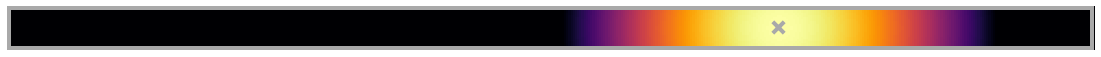

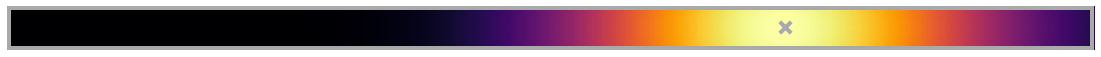

In [4]:
#FIGURE 3B
plotter2 = Visualiser(agent2)
N = 35


fig, ax = plotter2.plotReceptiveField(number=N)
saveFigure(fig,'closedLoopStart',specialLocation="../figures/paperFigures/figure3/3Bi.svg")

fig, ax = plotter2.plotPlaceField(time=30, number=N, STDP=True,threshold=0)
saveFigure(fig,'closedLoopEnd',specialLocation="../figures/paperFigures/figure3/3Bii.svg")

placeFields = agent2.getPlaceFields(M=agent2.W,threshold=0)
x = agent2.discreteCoords[10,:,0]
skew_PF = []
skew_RF = []
shift = []
for N in range(15,35):
    pf = placeFields[N][10,:]
    rf = agent2.discreteStates[10,:,N]
    (peak_pf, _, _, skew_pf) = peakMeanStdSkew(x,pf)
    (peak_rf, _, _, skew_rf) = peakMeanStdSkew(x,rf)
    peak_shift = peak_pf - peak_rf
    shift.append(peak_shift)
    skew_PF.append(skew_pf)
    skew_RF.append(skew_rf)
print('peak shift           = %.2f +- %.2f' %(np.mean(shift),np.std(shift)))
print('receptive field skew =  %.2f +- %.2f' %(np.mean(skew_RF),np.std(skew_RF)))
print('place field skew     = %.2f +- %.2f' %(np.mean(skew_PF),np.std(skew_PF)))

Eccentricity = 0.008
Eccentricity = 0.541
wall cells, eccentricity    =  0.54 +- 0.07  (N=24) 
centre cells, eccentricity  =  0.38 +- 0.09  (N=32) 
z = 7.227 --> p = 0.00000000


/Users/tomgeorge/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


'../figures/211011/eccentricityBoxplot_1132'

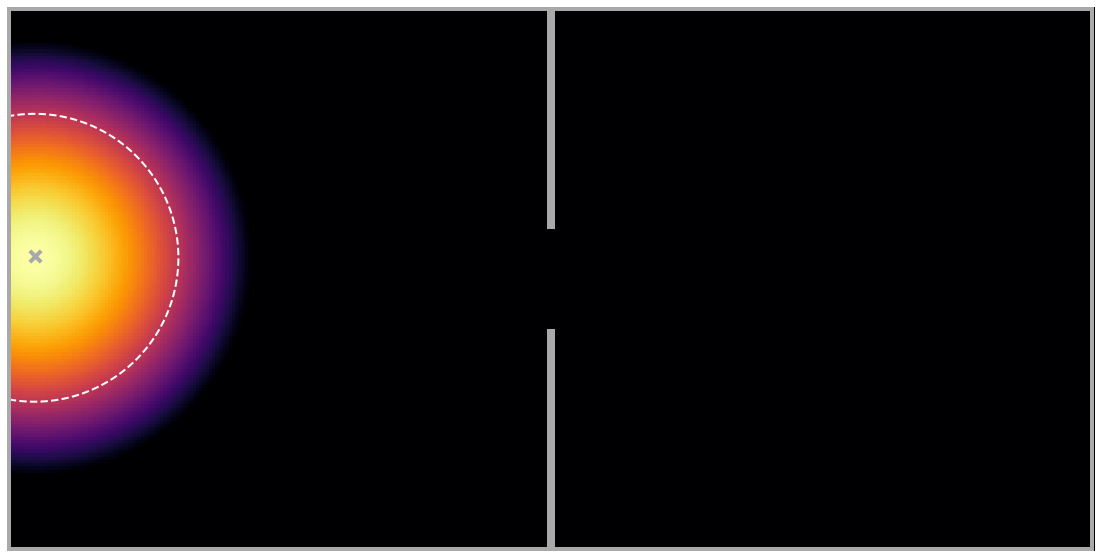

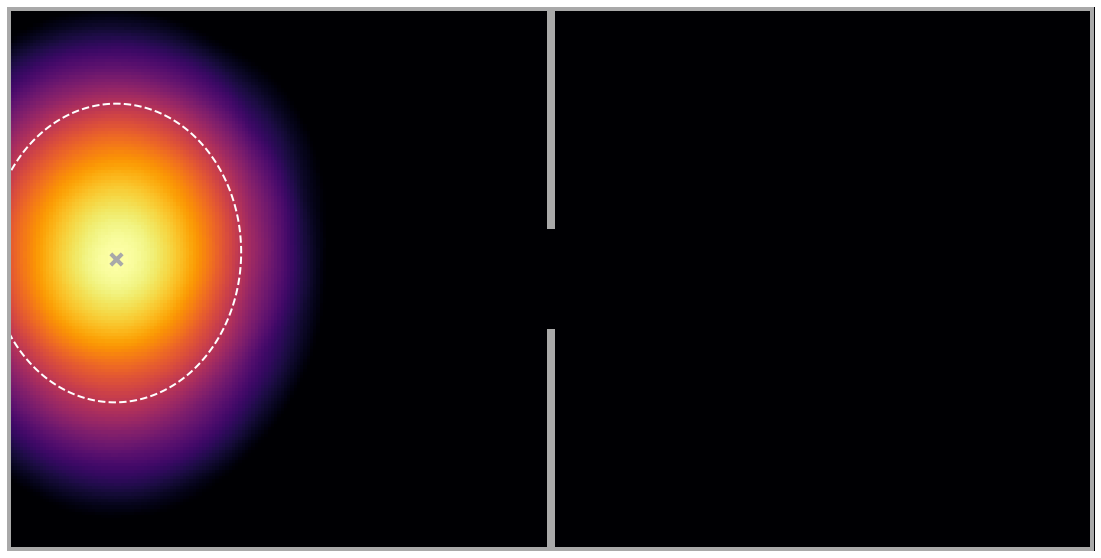

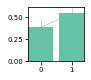

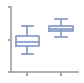

In [5]:
#FIGURE 3C
plotter3 = Visualiser(agent3)
#find cell near wall
cellID = np.argmin(np.linalg.norm(agent3.centres - np.array([0,1.25]),axis=1))


fig, ax = plotter3.plotReceptiveField(number=cellID, fitEllipse_=True)
saveFigure(fig,'2DMazeSideStart',specialLocation="../figures/paperFigures/figure3/3Ci.svg")

fig, ax = plotter3.plotPlaceField(number=cellID, STDP=True,fitEllipse_=True,threshold=0.2)
saveFigure(fig,'2DMazeSideEnd',specialLocation="../figures/paperFigures/figure3/3Cii.svg")

if True:
    placeFields = agent3.getPlaceFields(M=agent3.W,threshold=0.5)
    coords = agent3.discreteCoords
    eccen_wall = []
    eccen_centre = []
    for i in range(agent3.nCells):
    # for i in range(10):
        x,y = agent3.centres[i][0],agent3.centres[i][1] 
        if ((0.75 < x < 1.75) or (3.25 < x < 4.25)) and (0.75 < y < 1.75): 
            (X,Y,Z),e = fitEllipse(placeFields[i],coords=coords,verbose=False)
            eccen_centre.append(e)
        # else:
        elif ((((x < 0.25) or (x > 4.75)) and (0.75 < y < 1.75)) or 
              (((0.75 < x < 1.75) or (3.25 < x < 4.25)) and ((y < 0.25) or (y > 2.25)))):
            (X,Y,Z),e = fitEllipse(placeFields[i],coords=coords,verbose=False)
            eccen_wall.append(e)


    z = (np.mean(eccen_wall) - np.mean(eccen_centre))/np.sqrt(np.std(eccen_wall)**2/len(eccen_wall) + np.std(eccen_centre)**2/len(eccen_centre))
    # z = (np.mean(eccen_wall) - np.mean(eccen_centre))/np.sqrt(np.std(eccen_wall)**2/ + np.std(eccen_centre)**2)
    p = scipy.stats.norm.sf(z) #one-sided  
    
    print("wall cells, eccentricity    =  %.2f +- %.2f  (N=%g) " %(np.mean(eccen_wall),np.std(eccen_wall),len(eccen_wall)))
    print("centre cells, eccentricity  =  %.2f +- %.2f  (N=%g) " %(np.mean(eccen_centre),np.std(eccen_centre),len(eccen_centre)))
    print("z = %.3f --> p = %.8f" %(z,p))

fig, ax = plt.subplots(figsize=(1,1))
ax.bar([0,1],[np.mean(eccen_centre),np.mean(eccen_wall)])
ax.errorbar([0,1],[np.mean(eccen_centre),np.mean(eccen_wall)],[np.std(eccen_centre),np.std(eccen_wall)])

fig, ax = plt.subplots(figsize=(1.2,1.2))
bp = ax.boxplot([eccen_centre,eccen_wall],positions = [0.1,0.3],showfliers=False,widths=0.14)
for element in ['boxes', 'whiskers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='C2',linewidth=1.8)

for patch in bp['boxes']:
    patch.set(color='C2',linewidth=1.8)    

ax.set_ylim([0,0.8])
ax.set_xlim([0,0.4])
ax.spines['left'].set_position('zero')
ax.spines['left'].set_color('darkgrey')
ax.spines['left'].set_linewidth(1.8)
ax.spines['right'].set_color('none')        
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['top'].set_color('none')
ax.set_yticks([0,0.4,0.8])
ax.set_yticklabels(['','',''])
ax.set_xticks([0.1,0.3])
ax.set_xticklabels(['',''])
ax.tick_params(width=2,color='darkgrey')

saveFigure(fig,'eccentricityBoxplot',specialLocation="../figures/paperFigures/figure3/3Cii_inset.svg")




'../figures/211011/2DMazeDoorCreepEnd_1147'

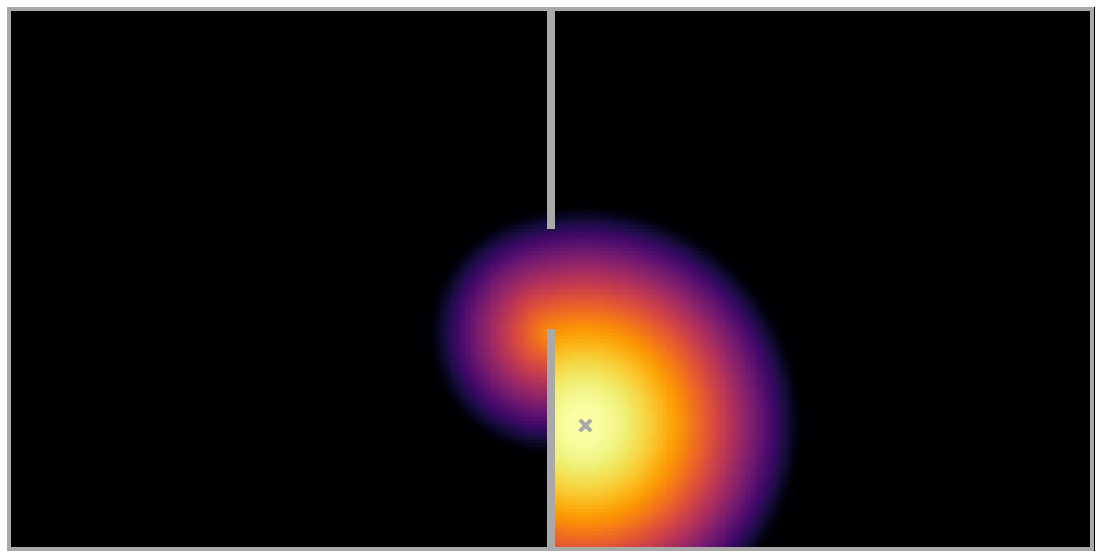

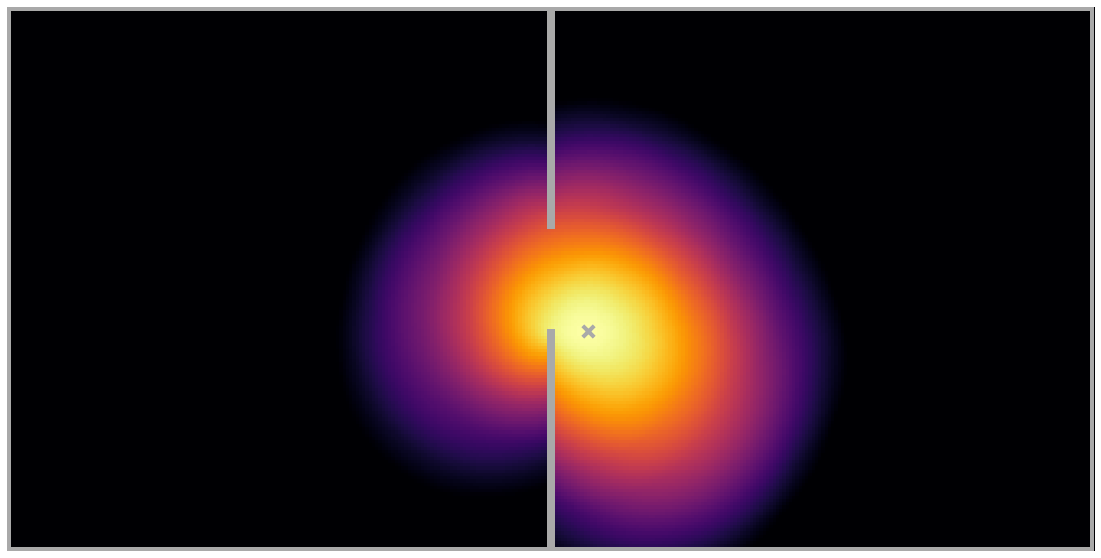

In [7]:
#FIGURE 3D
plotter3 = Visualiser(agent3)
#find cell just behind wall
cellID = np.argmin(np.linalg.norm(agent3.centres - np.array([2.6,0.5]),axis=1))

fig, ax = plotter3.plotReceptiveField(number=cellID)
saveFigure(fig,'2DMazeDoorCreepStart',specialLocation="../figures/paperFigures/figure3/3Di.svg")

fig, ax = plotter3.plotPlaceField(time=30, number=cellID, STDP=True,threshold=0.2)
saveFigure(fig,'2DMazeDoorCreepEnd',specialLocation="../figures/paperFigures/figure3/3Dii.svg")

In [31]:
N=50
xcen = np.linspace(0,5,N+1)[:-1]
xcen += (xcen[1] - xcen[0]) / 2
ycen = np.array([0.1]*N)
centres = np.vstack((xcen,ycen)).T
centres = np.vstack((centres,centres,centres))
sigmas = np.array([0.5]*N  + [1]*N + [1.5]*N)

#Default parameters for MazeAgent 
params4 = { 

          #Maze params 
          'mazeType'            : 'loop',                #type of maze, define in getMaze() function
          'stateType'           : 'gaussianThreshold',   #feature on which to TD learn (onehot, gaussian, gaussianCS, circles, bump)
          'movementPolicy'      : 'windowsScreensaver',  #movement policy (raudies, random walk, windows screensaver)
          'roomSize'            : 5,                     #maze size scaling parameter, metres
          'dt'                  : 0.002,                 #simulation time disretisation 
          'dx'                  : 0.01,
          'centres'             : centres,               #array of receptive field positions. Overwrites nCells
          'sigma'               : sigmas,                     #basis cell width scale (irrelevant for onehots)
          'doorsClosed'         : False,                 #whether doors are opened or closed in multicompartment maze
          'reorderCells'        : False,
         
          'kappa'               : 1,
          'tau'                 : 4,
          'tau_STDP'            : 20e-3,
          'precessFraction'     : 0.6, 
          'peakFiringRate'      : 5,  
          'a_STDP_asymm'        : -0.8,
          'tau_STDP_asymm'      : 2
          }

agent4 =  MazeAgent(params4)



Setting parameters
Initialising
   making state/history dataframes
   initialising velocity, position and direction
   setting time/run counters
   making the maze walls
   discretising position for later plotting
   handling undefined parameters
   initialising basis features for learning
   calculating state vector at all discretised positions


  0%|          | 0/10000 [00:00<?, ?it/s]

   initialising STDP weight matrix and traces
DONE


'../figures/211011/openloop_threetypes_1314_1'

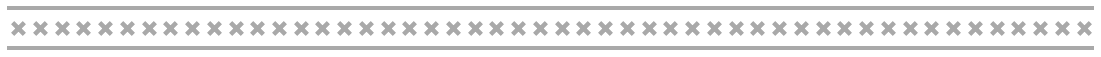

In [32]:
#FIGURE 4A 
plotter4 = Visualiser(agent4)
fig, ax = plotter4.plotFeatureCells(centresOnly=True, textlabel=False,threetypes=False)
saveFigure(fig,'openloop_threetypes',specialLocation="../figures/paperFigures/figure4/4C.svg")

  0%|          | 0/900000 [00:00<?, ?it/s]

Calculating place and grid cells


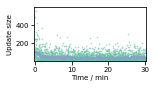

In [33]:
agent4.runRat(trainTime=30,saveEvery=0.5)
plotter4 = Visualiser(agent4)

'../figures/211011/W_ondiag_1445'

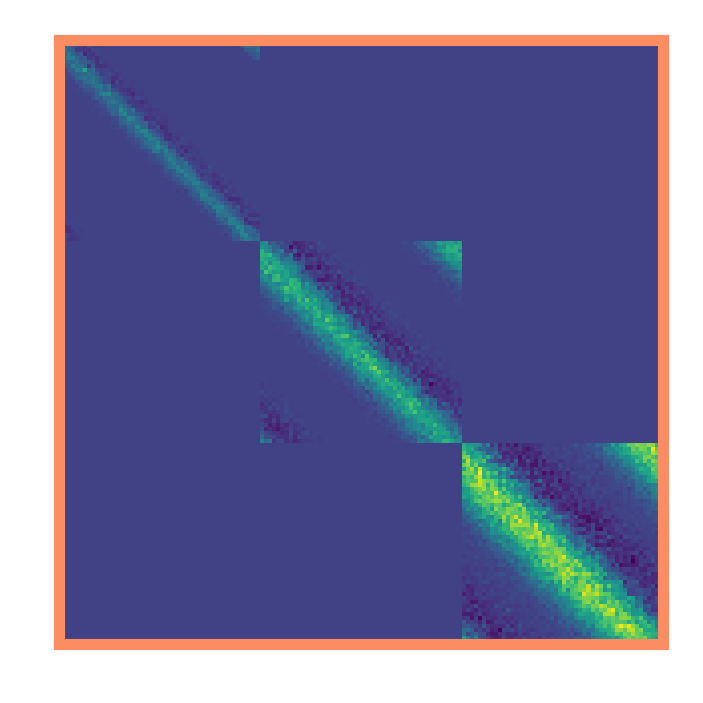

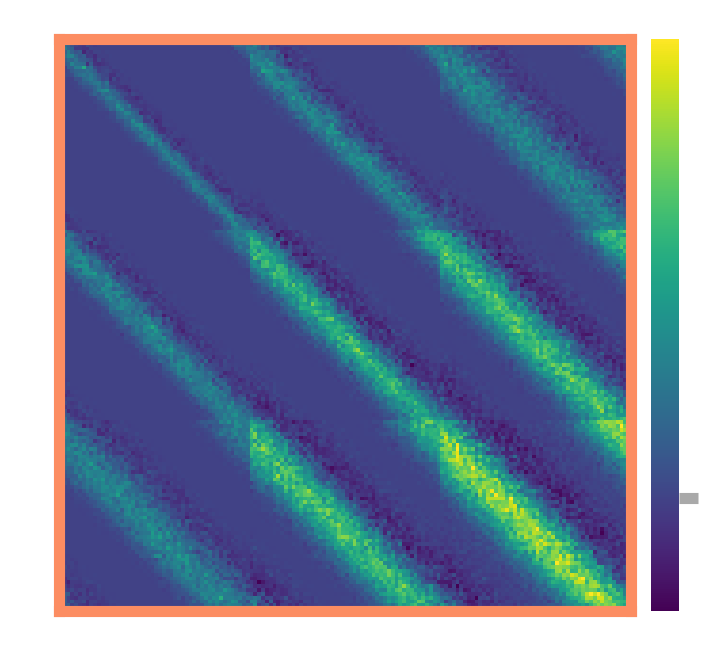

In [44]:
W_onDiag = agent4.W.copy()
for i in range(agent4.nCells):
    for j in range(agent4.nCells):
        if i < 50: 
            if j >= 50: 
                W_onDiag[i,j] = 0 
        elif 50 <= i < 100:
            if j < 50 or j >= 100: 
                W_onDiag[i,j] = 0 
        elif i >= 100: 
            if j < 100: 
                W_onDiag[i,j] = 0

agent4.W_onDiag = W_onDiag
plotter4 = Visualiser(agent4)



fig, ax = plotter4.plotM(M=agent4.W_onDiag,colorbar=False,colormatchto='W_onDiag')
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C1')
    spine.set_linewidth(2)
ax.set_xticks([])
ax.set_yticks([])
saveFigure(fig,'W',specialLocation='../figures/paperFigures/figure4/4D.svg')

fig, ax, cb, cax = plotter4.plotM(M=agent4.W,colorbar=True,colormatchto='W_onDiag')
ax.axis('on')
for spine in ax.spines.values():
    spine.set_color('C1')
    spine.set_linewidth(2)
ax.set_xticks([])
ax.set_yticks([])
cb.set_ticks([0])
cb.set_ticklabels([""])
cax.tick_params(color='darkgrey',width=2)
saveFigure(fig,'W_ondiag',specialLocation='../figures/paperFigures/figure4/4F.svg')


# #FIGURE 2M
# fig, ax, cb, cax = plotter4.plotM()
# ax.axis('on')
# for spine in ax.spines.values():
#     spine.set_color('C0')
#     spine.set_linewidth(2)
# cb.set_ticks([0])
# cb.set_ticklabels([""])
# cax.tick_params(color='darkgrey',width=2)
# ax.set_xticks([])
# ax.set_yticks([])
# saveFigure(fig,'M',specialLocation='../figures/paperFigures/figure4/4E.svg')

(150, 20, 500)
Place field     (peak, mean, std, skew) = (2.345, 2.328, 0.298, -0.101)
(150, 20, 500)
Place field     (peak, mean, std, skew) = (2.185, 2.116, 0.567, -0.205)
(150, 20, 500)
Place field     (peak, mean, std, skew) = (1.935, 1.89, 0.782, 0.055)
(150, 20, 500)
Place field     (peak, mean, std, skew) = (2.235, 2.096, 0.648, -0.213)
(150, 20, 500)
Place field     (peak, mean, std, skew) = (2.205, 2.026, 0.679, -0.232)
(150, 20, 500)
Place field     (peak, mean, std, skew) = (2.075, 1.933, 0.711, -0.113)


'../figures/211011/pc_large_1457_4'

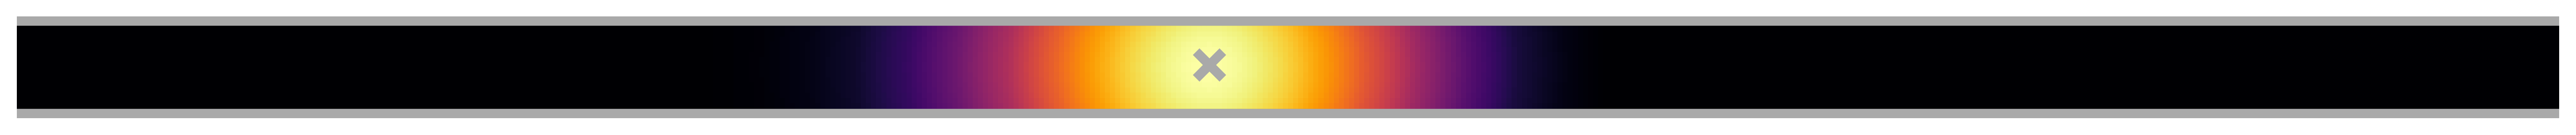

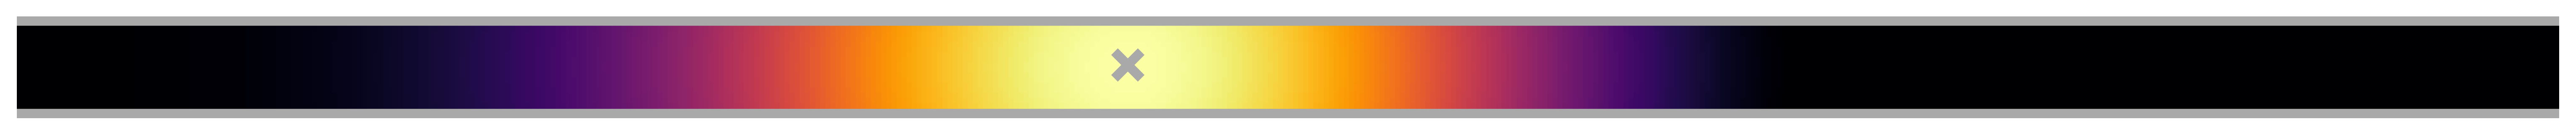

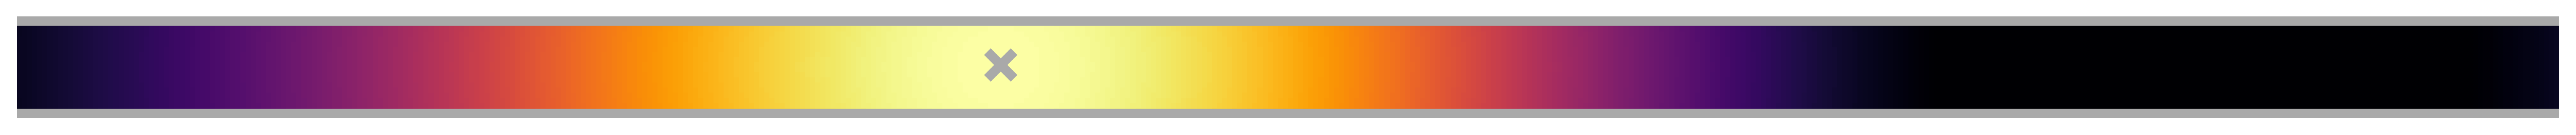

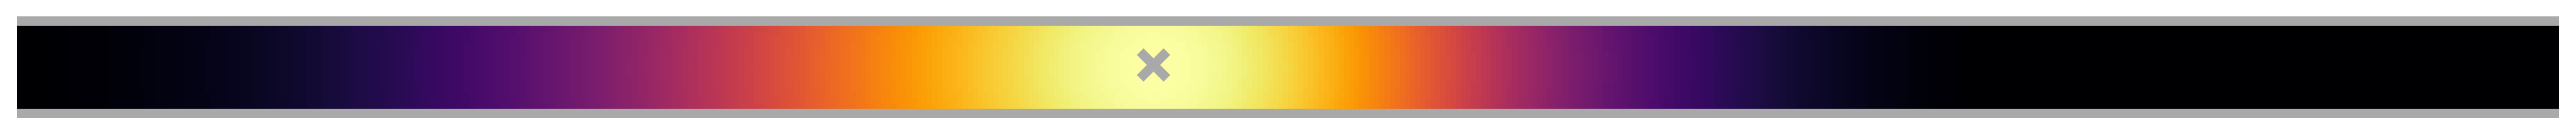

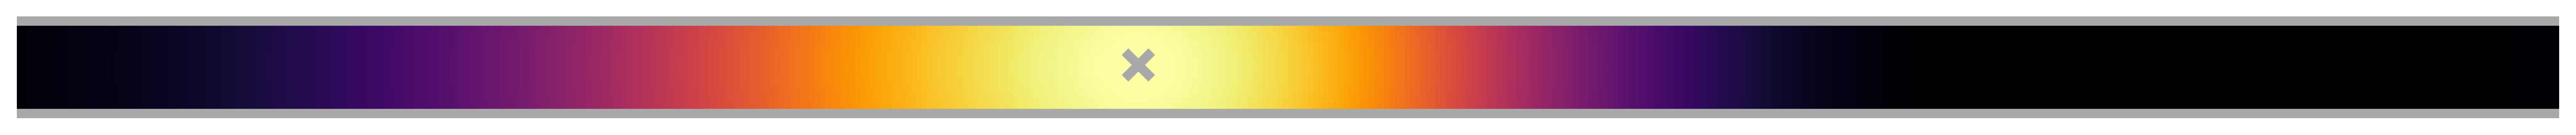

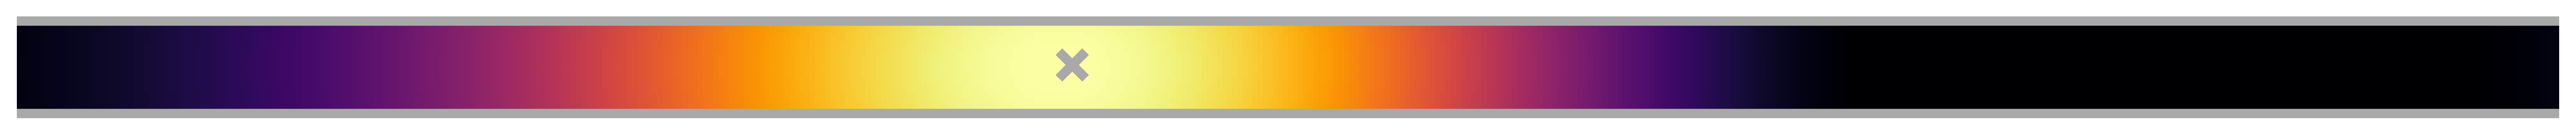

In [55]:
N = [25,75,125]

fig, ax = plotter4.plotPlaceField(number=25, M=agent4.W_onDiag,threshold=0)
saveFigure(fig,'pc_small',specialLocation="../figures/paperFigures/figure4/4ei.svg")

fig, ax = plotter4.plotPlaceField(number=75, M=agent4.W_onDiag,threshold=0)
saveFigure(fig,'pc_medium',specialLocation="../figures/paperFigures/figure4/4eii.svg")

fig, ax = plotter4.plotPlaceField(number=125, M=agent4.W_onDiag,threshold=0)
saveFigure(fig,'pc_large',specialLocation="../figures/paperFigures/figure4/4eiii.svg")

fig, ax = plotter4.plotPlaceField(number=25, M=agent4.W,threshold=0)
saveFigure(fig,'pc_small',specialLocation="../figures/paperFigures/figure4/4gi.svg")

fig, ax = plotter4.plotPlaceField(number=75, M=agent4.W,threshold=0)
saveFigure(fig,'pc_medium',specialLocation="../figures/paperFigures/figure4/4gii.svg")

fig, ax = plotter4.plotPlaceField(number=125, M=agent4.W,threshold=0)
saveFigure(fig,'pc_large',specialLocation="../figures/paperFigures/figure4/4giii.svg")


In [ ]:
#FIGURE 4A
N=50
loopsize=5
xcen = np.linspace(0,loopsize,N+1)[:-1]
xcen += (xcen[1] - xcen[0]) / 2
ycen = np.array([0.1]*N)
centres = np.vstack((xcen,ycen)).T

sigmas = [0.25,0.5,0.75,1,1.25,1.5,1.75,2]
w_bank = np.zeros(shape=(len(sigmas),N,N))

for (i, sigma) in enumerate(sigmas):
    parameters = {
            #Maze params 
            'mazeType'            : 'loop',  #type of maze, define in getMaze() function
            'stateType'           : 'bump', #feature on which to TD learn (onehot, gaussian, gaussianCS, circles, bump)
            'movementPolicy'      : 'windowsScreensaver',  #movement policy (raudies, random walk, windows screensaver)
            'roomSize'            : loopsize,          #maze size scaling parameter, metres
            'dt'                  : 0.005,       #simulation time disretisation 
            'centres'             : centres,       #array of receptive field positions. Overwrites nCells
            'sigma'               : sigma,          #basis cell width scale (irrelevant for onehots)
            'doorsClosed'         : False,       #whether doors are opened or closed in multicompartment maze
            #TD params 
            'tau'                 : 3,          #TD decay time, seconds
            'TDdx'                : 0.01,       #rough distance between TD learning updates, metres 
            'alpha'               : 0.01,       #TD learning rate 
            'successorFeatureNorm': 100,        #linear scaling on successor feature definition found to improve learning stability
            #STDP params
            'a_pre'               : 1,          #bump in cell 'presynaptic trace' when it spikes
            'a_post'              : 0.7,      #bump in cell 'postsynaptic trace' when it spikes
            'precessFraction'     : 1,        #fraction of 2pi the prefered phase moves through
            'peakFiringRate'      : 20,         #peak firing rate of a cell (middle of place field, preferred theta phase)
            'eta_pre'             : 0.05,        #learning rate for pre to post strengthening 
            'eta_post'            : 0.05,        #learning rate for post to pre weakening
            'kappa'               : 1,        #von mises spread parameter (smaller = wider)
            'tau_pre'             : 20e-3,      #rate potentiating trace decays
            'tau_post'            : 20e-3,      #rate depressing trace decays 
            'baselineFiringRate'  : 0
    }

    agentsigma =  MazeAgent(parameters)
    agentsigma.runRat(trainTime=10,TDSRLearn=False)
    w_bank[i] = agentsigma.W


In [ ]:
taus = np.zeros(len(sigmas))
taus_sigma = np.zeros(len(sigmas))

for (i,sigma) in enumerate(sigmas):
    t = []
    w_shifted = np.zeros_like(agentsigma.W)
    w = w_bank[i]
    for j in range(agentsigma.nCells):
        w_shifted[j,:] = np.roll(w[j,:],-j)
    w_shifted_mean = np.mean(w_shifted,axis=0)
    b = np.argmax(w_shifted_mean)
    plt.plot(w_shifted_mean)
    max_binding = w_shifted_mean[b]
    while True: 
        if w_shifted_mean[b] <= max_binding / np.e:
            t = agentsigma.nCells - b
            break
        else: 
            b -= 1 
    tau =  t * (agentsigma.roomSize / agentsigma.nCells) / (agentsigma.speedScale)
    taus[i] = tau

taus_plot = taus
taus_sigma_plot = taus_sigma
sigmas_plot = sigmas



fig, ax = plt.subplots(figsize=(2,2))
[m,c] = np.polyfit(sigmas_plot,taus_plot,deg=1)
x = np.linspace(0,sigmas_plot[-1],100)
y = m*x + c
color = ['darkgrey'] * len(sigmas)
color[1],color[3],color[5] = 'C2','#B696C7','C3'
size = [25] * len(sigmas)
ax.scatter(sigmas_plot,taus_plot,s=size,c=color)
# ax.errorbar(sigmas_plot,taus_plot,taus_sigma_plot,ls="none",c=color)
ax.plot(x,y,c='darkgrey',linestyle='--',linewidth=1)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0,right=sigmas_plot[-1]+0.1)
ax.spines['left'].set_position('zero')
ax.spines['left'].set_color('darkgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_color('none')        
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_color('none')
ax.set_xticks([0,0.5,1,1.5,2])
ax.set_xticklabels(['','','','',''])
ax.set_yticks([0,2,4,6,8,10])
ax.set_yticklabels(['','','','',''])
ax.tick_params(width=2,color='darkgrey')

saveFigure(fig,"tausigma",specialLocation="../figures/paperFigures/figure4/4A.svg")


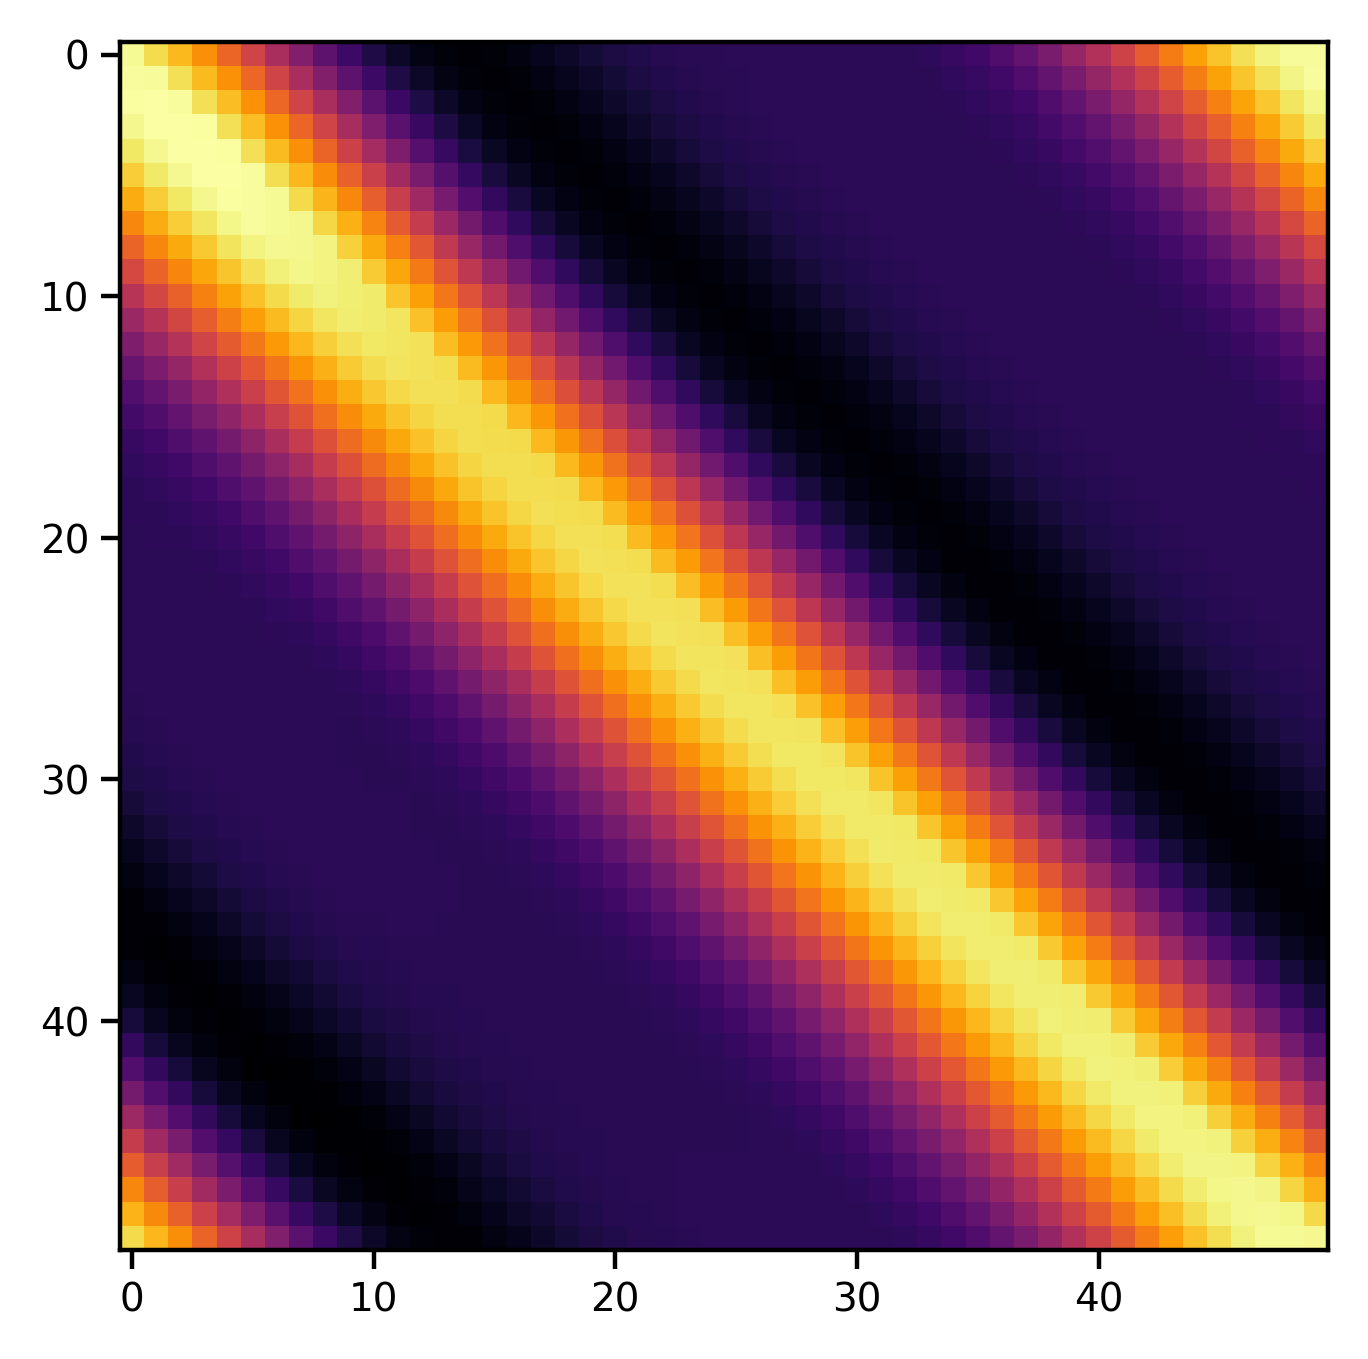

In [88]:
M_true = agent.M
plt.imshow(M_true)

In [98]:
agent.W_notheta

array([[ 4.98518852,  8.9433843 , -0.73438732, ...,  0.32844131,
        -0.89838564, 21.73654559],
       [-1.4701212 ,  4.31802037, 12.01531332, ...,  0.40045089,
         5.56757409,  8.67997461],
       [ 6.20736318, -2.80465058,  5.62173906, ...,  7.67121234,
         7.77808928,  0.08186741],
       ...,
       [ 6.82361027,  7.76877889, -2.09567335, ...,  3.49035258,
         0.60608232,  3.30637613],
       [ 4.95791411,  3.19118089, -0.69620463, ...,  9.93693302,
         0.76407347,  4.81981597],
       [-7.17615102,  0.0735595 ,  4.59682607, ...,  8.84418091,
         5.20797965,  2.52123231]])

(-2.308, 1.676, 0.549)


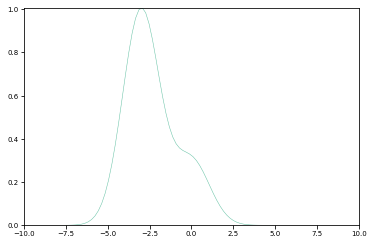

In [221]:
#skew
x = np.linspace(-10,10,100)
mu = 3
sigma = 1.1
y = np.exp(-(-x-mu)**2/(2*sigma**2)) + 0.3*np.exp(-(x)**2/(2*sigma**2))
plt.plot(x,y)

def functionMeanAndStd(X,Y):
    s_xy = 0
    s_y  = 0
    for (x,y) in zip(X,Y):
        s_xy += x*y
        s_y  += y 
    mean = s_xy/s_y

    s_var = 0
    for (x,y) in zip(X,Y):
        s_var += y*(x-mean)**2
    var = s_var/s_y
    std = var**0.5

    s_skew = 0 
    for (x,y) in zip(X,Y):
        s_skew += y*((x-mean)/std)**3
    skew = s_skew/s_y


    return round(mean,3), round(std,3), round(skew,3)

print(functionMeanAndStd(x,y))

In [249]:
np.identity(5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [71]:
agent3.discreteCoords.reshape(-1,2).shape

(5000, 2)